In [25]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [26]:
# === Load model ===
model = load_model('model_transfer_learning.h5')

In [27]:
# === Get class map from dataset folder ===
root_dataset_dir = 'pre_process_data'
class_names = sorted(os.listdir(root_dataset_dir))
class_map = {idx: name for idx, name in enumerate(class_names)}

In [28]:
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

In [29]:
print(class_to_idx)

{'Crow': 0, 'Dog': 1, 'Moon': 2, 'Punkalasa': 3, 'Snake': 4, 'Sun': 5, 'Watapatha': 6}


In [30]:
# === Image size used in training ===
IMG_SIZE = (244, 244)

In [31]:
def to_grayscale(img):
    return cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

def apply_clahe(gray_img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(gray_img)

def denoise_image(img):
    img = (img * 255).astype(np.uint8)
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def boost_contrast(gray_img):
    return cv2.equalizeHist(gray_img)

def random_flip(img):
    if random.random() > 0.5:
        return np.fliplr(img)
    return img

In [32]:
def preprocess_images(X, augment=False, to_gray=False):
    processed = []

    for img in X:
        if augment:
            img = random_flip(img)

        img_rgb = (img * 255).astype(np.uint8)

        if to_gray:
            img = to_grayscale(img)
            img = apply_clahe(img)
            img = boost_contrast(img)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img = denoise_image(img)
        img = sharpen_image(img)

        img = img.astype(np.float32) / 255.0
        processed.append(img)

    return np.array(processed)

In [33]:
def predict_and_show(image_path, augment=False, to_gray=False):
    # Load and resize the image
    original_img = Image.open(image_path).convert("RGB").resize(IMG_SIZE)
    img_array = np.array(original_img).astype(np.float32) / 255.0  # Normalize to [0,1]

    # Preprocess image
    processed_image = preprocess_images([img_array], augment, to_gray)  # Wrap in list for batch processing

    # Predict using the model
    prediction = model.predict(processed_image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_map[predicted_class_index]
    confidence = np.max(prediction)

    print(f"Predicted class: {predicted_class} (Confidence: {confidence*100:.2f}%)")

    # Visualize original and preprocessed image
    preprocessed_img = np.squeeze(processed_image, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(preprocessed_img)
    axes[1].set_title(f"Preprocessed Image\nPrediction: {predicted_class}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: Watapatha (Confidence: 100.00%)


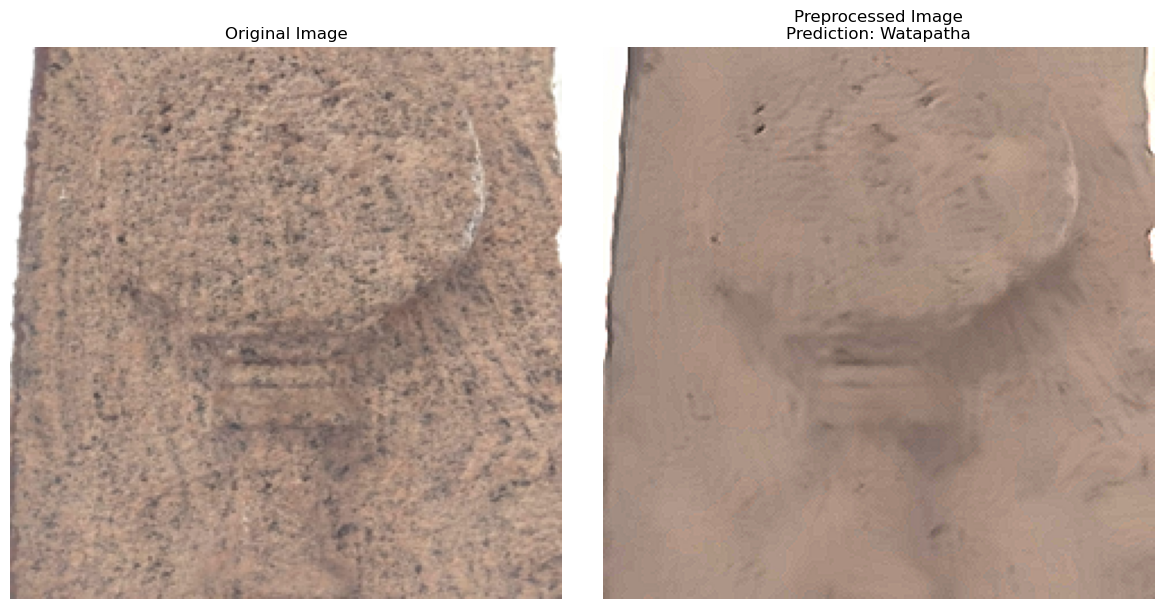

In [42]:
# Example: Test with a specific image
test_image_path = 'Model_Test_Data/Watapatha2.jpeg'  
predict_and_show(test_image_path)